In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

from models import deconvolution
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx",
    'font.size': 20
})
np.random.seed(42)

In [2]:
def problem_system_combined(grid: np.array)-> np.array:
    params = [0, 0.7, 0., 1.0, 0]
    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= -0.6:
            output[idx] = params[0]
        elif point <= 0.0:
            output[idx] = params[1]+ 0.2*np.sin(1.7*np.pi*point*2)
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.6:
            #output[idx] = params[3]
            output[idx] = params[3] + 0.3*np.sin(2*np.pi*point*2)
        else:
            output[idx] = point*params[4]
    
    return output

def problem_system_discrete(grid: np.array)-> np.array:

    
    params = [0., 0.8, 0., -0.7, 0.0, 0.8, 0.]

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= -0.6:
            output[idx] = params[0]
        elif point <= -0.5:
            output[idx] = params[1]
        elif point <= 0.0:
            output[idx] = params[2]
        elif point <= 0.2:
            output[idx] = params[3]
        elif point <= 0.5:
            output[idx] = params[4]
        elif point <= 0.6:
            output[idx] = params[5]
        else:
            output[idx] = params[6]
    
    return output


def problem_system_continuous(grid: np.array)-> np.array:

    # Define boundary and internal points
    x = np.array([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.3, -0.1, 0.0, 0.2, 0.5, 0.6, 1])
    y = np.array([0, 0.0, 0.0, -0.6, 0., 0.6, 0.2,  -0.1, 0.4, 0.8, 0.1, -0.1, -0.2])

    # Create a cubic spline interpolation of the points
    cs = CubicSpline(x, y)
    output = cs(grid)
    
    return output

In [3]:
n_t = 100
n_y = 100
domain = [-1, 1]


In [4]:

# Generate the grid
t = np.linspace(domain[0],domain[1], n_t)
t = np.round(t, 3)
h = domain[1] / n_t
# Create the convolution matrix A
model = deconvolution(int(np.round(n_y/8)), int(n_y/16), 'reflect')
A = model.linear_operator(n_t)
A = A[::round(n_t/n_y), :]
#A[0,0] = 0
#A[-1, -1] = 0


# Generate grid points
x = np.linspace(domain[0], domain[1] - h, n_y)
# Construct the true function
true = problem_system_continuous(t)

true = true.reshape(-1,1)
temp = A@true
#ind = temp > 0
#temp *= ind

# Create y_data with noise
y_data_additive = temp + np.random.normal(0, 0.1, temp.shape)
y_data_multiplicative = temp+ temp*np.random.normal(0, 0.3, temp.shape)

In [5]:
plt.plot(t, temp)
plt.plot(t, y_data_additive)
plt.axis([domain[0], domain[1], -1.0, 1.])
plt.savefig('../plots/misc/noise_examples_a.eps', format='eps')

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f9ed08ea7a0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

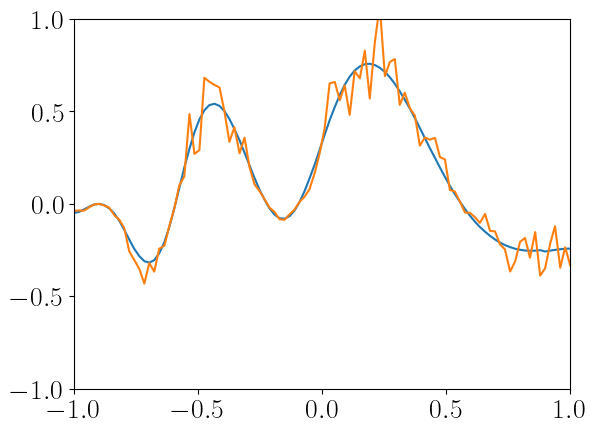

In [71]:
plt.plot(t, temp)
plt.plot(t, y_data_multiplicative)
plt.axis([domain[0], domain[1], -1.0, 1.])
plt.savefig('../plots/misc/noise_examples_b.eps', format='eps')

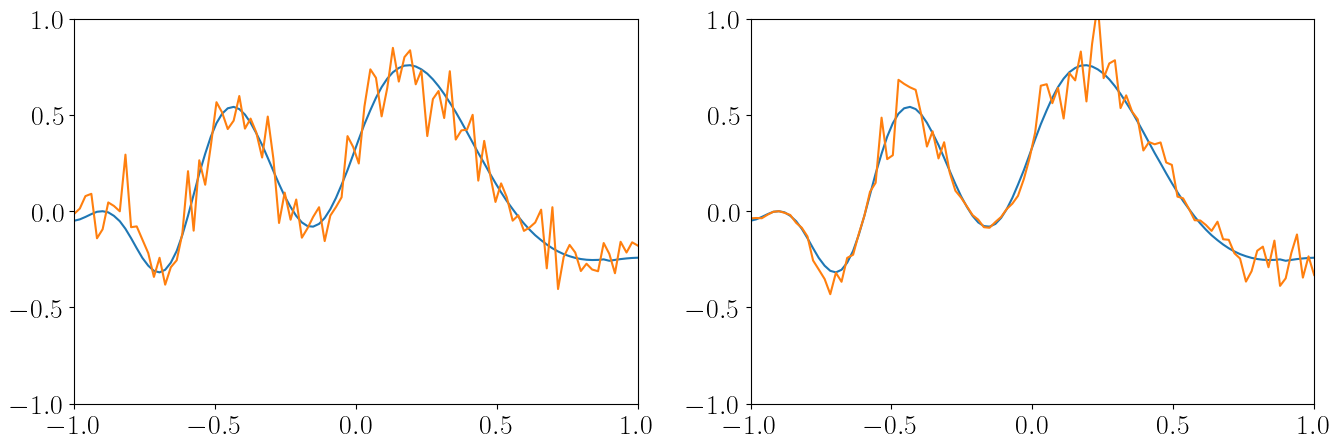

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(t, temp)
axs[0].plot(t, y_data_additive)
axs[0].axis([domain[0], domain[1], -1.0, 1.0])

axs[1].plot(t, temp)
axs[1].plot(t, y_data_multiplicative)
axs[1].axis([domain[0], domain[1], -1.0, 1.0])
plt.savefig('../plots/misc/noise_examples.eps', format='eps')

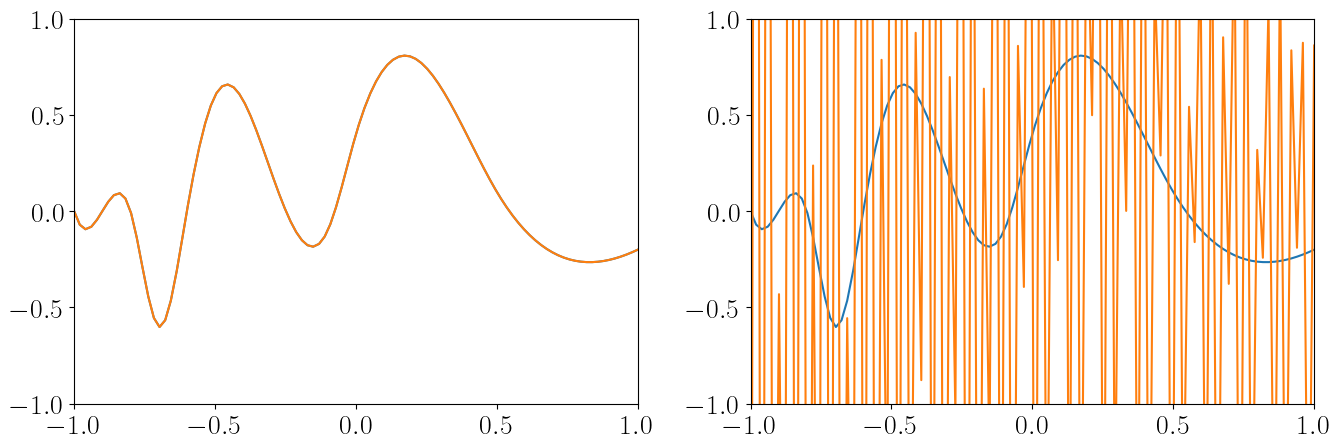

In [68]:
x_no_noise = np.linalg.inv(A) @ temp
x_noise = np.linalg.inv(A) @ y_data_additive

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(t, true)
axs[0].plot(t, x_no_noise)
axs[0].axis([domain[0], domain[1], -1.0, 1.0])

axs[1].plot(t, true)
axs[1].plot(t, x_noise)
axs[1].axis([domain[0], domain[1], -1.0, 1.0])
plt.savefig('../plots/misc/direct_inversion.eps', format='eps')

In [13]:
np.eye(A.shape[0])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [26]:
alpha = 0.5
A_tikhonov = np.vstack([A, alpha*np.eye(A.shape[0])])
y_tikhonov = np.vstack([y_data_additive, np.zeros(y_data_additive.shape)])

tikhonov, _, _, _ = np.linalg.lstsq(A_tikhonov, y_tikhonov, rcond=None)


In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(t, true)
axs[0].plot(t, x_no_noise)
axs[0].axis([domain[0], domain[1], -1.0, 1.0])

axs[1].plot(t, true)
axs[1].plot(t, tikhonov)
axs[1].axis([domain[0], domain[1], -1.0, 1.0])
plt.savefig('../plots/misc/direct_inversion.eps', format='eps')

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f9ed08ea7a0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1600x500 with 2 Axes>